<h1 align="center" style="margin: 0; font-size: 36px;">Neural and Evolutionary Learning</h1>
<br>
<h1 align="center" style="margin: 0; font-size: 30px;">Project partial deliverable 1 (GP)</h1>

<br>

**Group members:**<br>
Bárbara Capitão - 20211532@novaims.unl.pt <br>
Carolina Silvestre - 20211512@novaims.unl.pt <br>
Lara Leandro - 20211632@novaims.unl.pt <br>


### Requirements
- Fit a GP to the project dataset, including the hyperparameter tuning phase.
- Discuss the bloat, overfitting, and premature convergence on the algorithm.
- Include your own insights and summary conclusion 

### Table of Contents
[Imports](#chapter_1) <br>
[Settings](#chapter_2) <br>
[Load Data](#chapter_3) <br>
[Data Understanding](#chapter_4) <br>
[Data Preprocessing](#chapter_5) <br>
[Cross-Validation](#chapter_6) <br>
[Genetic Programming](#chapter_7) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Problem Instance Definition](#subchapter_7_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Solve](#subchapter_7_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Evolution Graphs](#subchapter_7_3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Variation of RMSE across Models](#subchapter_7_3_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Train vs Test Fitness ](#subchapter_7_3_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness vs Size Evolution](#subchapter__7_3_4) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness Diversity](#s4bchapter_7_3_5) <br>
[To Evaluate](#chapter_8) <br>

<a id="chapter_1"></a>
## Imports


In [1]:
#! pip install slim_gsgp
#! pip install gplearn

In [120]:
import os
import random
import pickle
import datetime
from itertools import product
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Statistical tests
from scipy.stats import spearmanr, shapiro

# Symbolic regression 
from gplearn.genetic import SymbolicRegressor

# Custom modules
from slim_gsgp.datasets.data_loader import *
from slim_gsgp.main_gp import gp

import joblib


<a id="chapter_2"></a>
## Settings

In [3]:
seed = 43
np.random.seed(seed)

In [91]:
train_color = 'blue'
test_color = 'orange'
size_color = 'green'

<a id="chapter_3"></a>
## Load Data

In [5]:
# Load Excel file
df = pd.read_excel("sustavianfeed.xlsx")

In [6]:
df

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,V476,2633.1,1683.2,2034.1,1637.2,213.8,610.9,4.777,45.992,12.796,74.888,54.021,7.857,88.999126,1.07
92,V454,2346.2,1547.8,1819.5,1511.2,228.0,528.2,3.673,35.090,11.504,68.455,42.173,7.837,88.507288,1.13
93,V425,2648.2,1722.9,2050.0,1669.8,253.1,610.0,5.176,50.505,17.194,81.502,49.7,7.332,90.375587,1.91
94,V490,2262.6,1498.5,1813.9,1468.0,212.1,548.4,2.829,30.266,11.129,53.011,46.816,5.425,91.211353,2.21


In [7]:
# Droping ID column
df.drop(columns=['WING TAG'], inplace=True)

<a id="chapter_4"></a>
## Data Understanding

In [8]:
df.describe()

,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,2339.682292,1521.955208,1833.378125,1481.479167,234.116667,542.205208,4.219917,36.781427,12.059240,69.149156,8.184677,87.313708,2.090417
std,200.943424,144.126939,154.000550,142.830115,37.818405,60.994468,0.998836,5.438894,1.932239,11.727467,1.697425,2.043895,1.351645
min,1968.400000,1284.900000,1554.400000,1252.600000,177.100000,177.800000,2.464000,25.916000,8.561000,44.133000,5.425000,73.837184,0.320000
25%,2201.775000,1425.775000,1723.800000,1380.825000,218.775000,508.225000,3.534250,33.053000,10.584250,62.274250,7.012750,86.544416,1.130000
50%,2299.500000,1493.050000,1809.400000,1452.800000,231.550000,538.100000,4.048000,35.936000,11.679000,68.019500,7.809500,87.574947,1.710000
75%,2473.800000,1608.400000,1922.725000,1573.700000,243.275000,573.850000,4.817000,40.485000,13.449750,75.103000,9.016750,88.508026,2.527500
max,2890.500000,1929.400000,2262.800000,1891.700000,533.200000,690.600000,7.758000,53.133000,17.194000,123.171000,13.170000,91.211353,6.680000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WEIGHT                             96 non-null     float64
 1   HOT CARCASS WEIGHT                 96 non-null     float64
 2   CARCASS WEIGHT WITH HEAD AND LEGS  96 non-null     float64
 3   COLD CARCASS WEIGHT                96 non-null     float64
 4   BREAST WEIGHT (2)                  96 non-null     float64
 5   THIGH WEIGHT (2)                   96 non-null     float64
 6   SPLEEN                             96 non-null     float64
 7   LIVER                              96 non-null     float64
 8   HEART                              96 non-null     float64
 9   INTESTINE                          96 non-null     float64
 10  EMPTY MUSCULAR STOMACH             96 non-null     object 
 11  GLANDULAR STOMACH                  96 non-null     float64
 

> The column 'EMPTY MUSCULAR STOMACH' has been read as type object, possibly because some entries contain non-numeric or unexpected values, preventing it from being interpreted as float

In [10]:
df['EMPTY MUSCULAR STOMACH'].value_counts()

EMPTY MUSCULAR STOMACH
/         5
75.767    2
47.964    1
51.322    1
59.583    1
         ..
63.571    1
49.648    1
43.586    1
53.456    1
46.816    1
Name: count, Length: 91, dtype: int64

> The 'EMPTY MUSCULAR STOMACH' as 5 values '/'

In [11]:
# Coverting the column to numeric, forcing '/' to became Nan
df['EMPTY MUSCULAR STOMACH'] = pd.to_numeric(df['EMPTY MUSCULAR STOMACH'], errors='coerce')

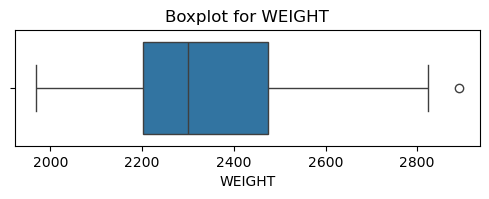

WEIGHT — Outliers detected: 1


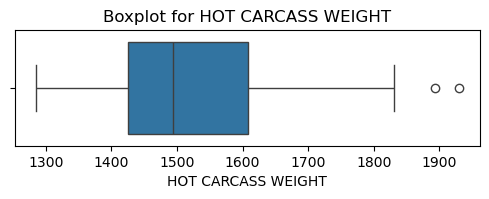

HOT CARCASS WEIGHT — Outliers detected: 2


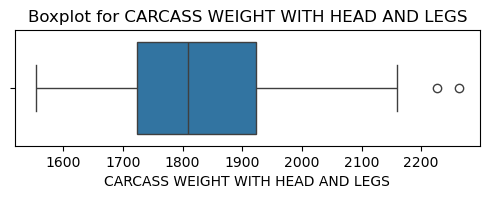

CARCASS WEIGHT WITH HEAD AND LEGS — Outliers detected: 2


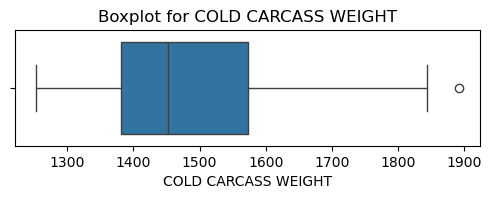

COLD CARCASS WEIGHT — Outliers detected: 1


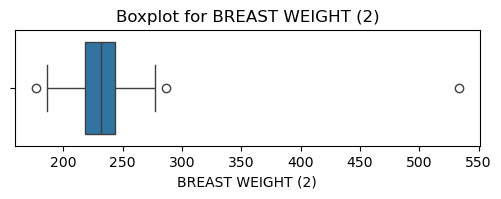

BREAST WEIGHT (2) — Outliers detected: 3


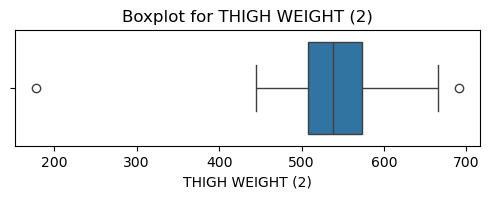

THIGH WEIGHT (2) — Outliers detected: 2


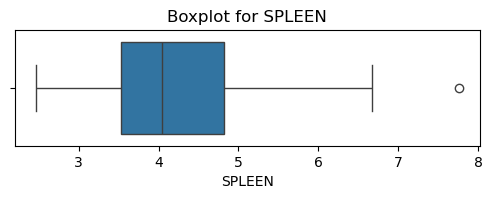

SPLEEN — Outliers detected: 1


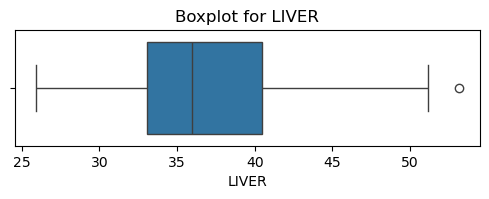

LIVER — Outliers detected: 1


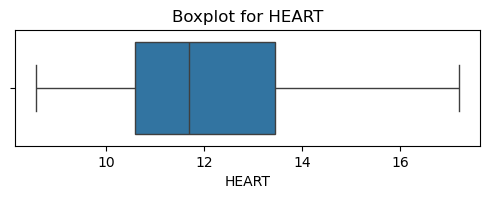

HEART — Outliers detected: 0


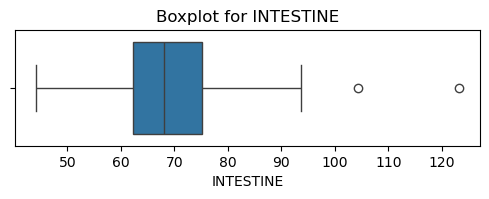

INTESTINE — Outliers detected: 2


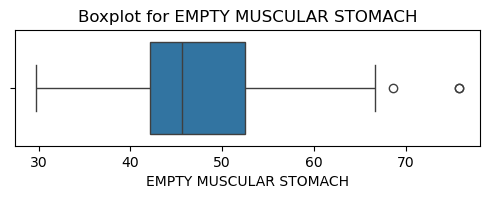

EMPTY MUSCULAR STOMACH — Outliers detected: 3


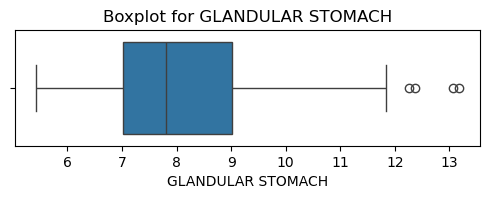

GLANDULAR STOMACH — Outliers detected: 4


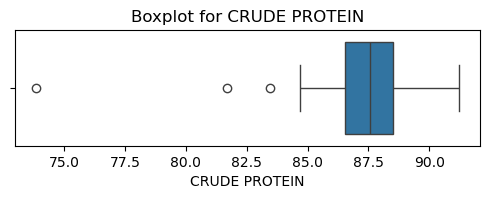

CRUDE PROTEIN — Outliers detected: 3


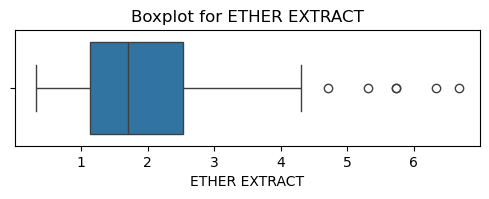

ETHER EXTRACT — Outliers detected: 6


In [12]:
def detect_outliers_iqr(df):
    outlier_info = {}

    for col in df.select_dtypes(include = [np.number] ).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Geting the outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_info[col] = {
            'count': outliers.count(),
            'outliers': outliers.values
        }

        # Ploting the boxplots
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col], orient='h' )
        plt.title(f"Boxplot for {col}")
        plt.show()

        print(f"{col} — Outliers detected: {outliers.count()}")
    
    return outlier_info

outlier_summary = detect_outliers_iqr(df)

Most columns contain some outliers, but they are few in number and not particularly extreme, so we’ve decided to keep them.
The most notable outliers appear in:

- Breast weight: typically ranges from 200–250, but one value is around 550.

- Thigh weight: usually between 450–650, but there's one outlier close to 200.

- Crude protein: generally falls between 85–95, but there's a value near 72.5.


 Analyzing column: WEIGHT


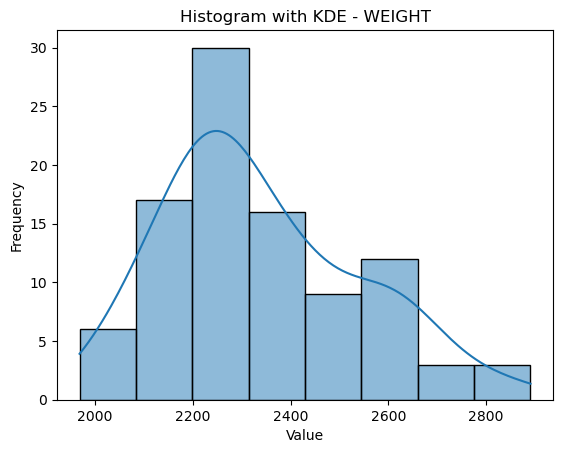

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0100
 Not normally distributed (reject H0)

 Analyzing column: HOT CARCASS WEIGHT


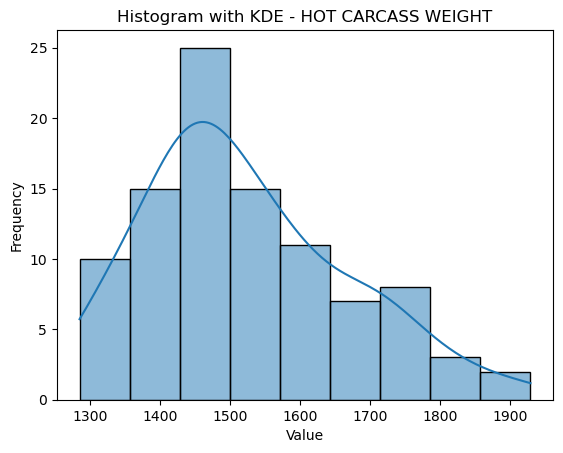

Shapiro-Wilk Test statistic = 0.9611, p-value = 0.0061
 Not normally distributed (reject H0)

 Analyzing column: CARCASS WEIGHT WITH HEAD AND LEGS


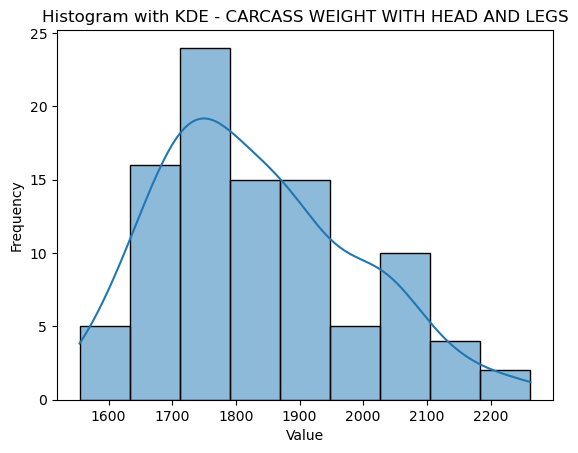

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0099
 Not normally distributed (reject H0)

 Analyzing column: COLD CARCASS WEIGHT


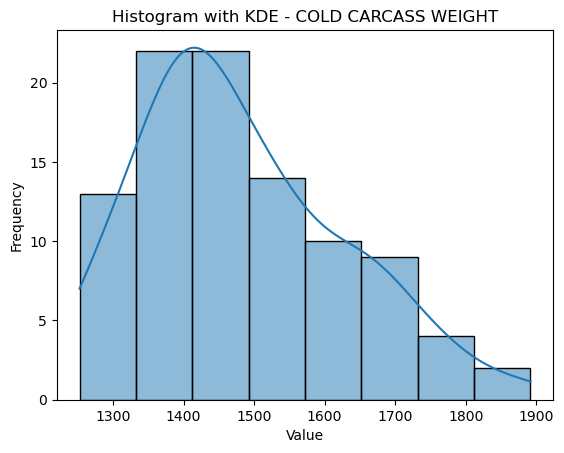

Shapiro-Wilk Test statistic = 0.9577, p-value = 0.0036
 Not normally distributed (reject H0)

 Analyzing column: BREAST WEIGHT (2)


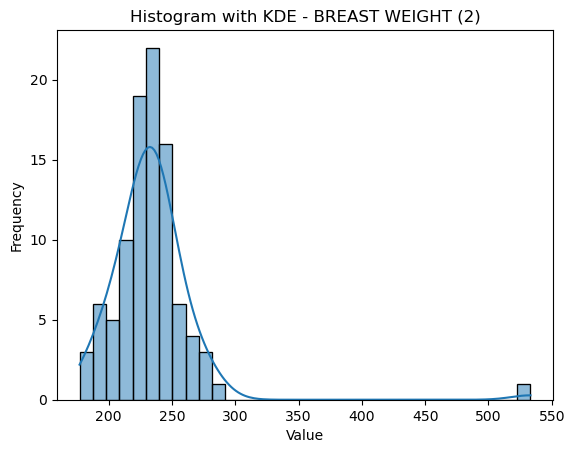

Shapiro-Wilk Test statistic = 0.6057, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: THIGH WEIGHT (2)


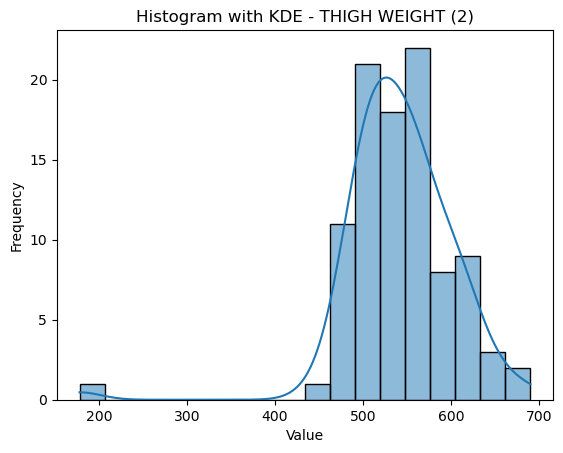

Shapiro-Wilk Test statistic = 0.8492, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: SPLEEN


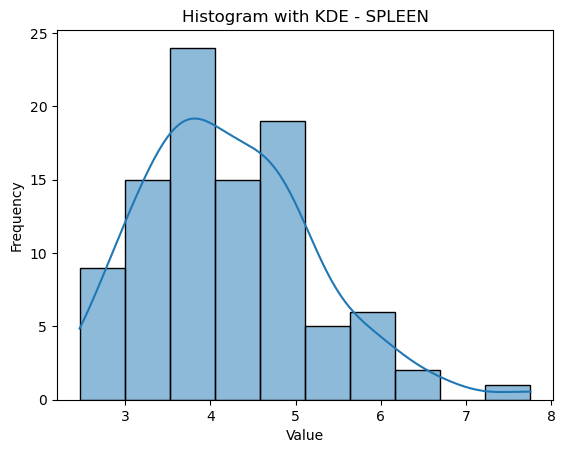

Shapiro-Wilk Test statistic = 0.9657, p-value = 0.0129
 Not normally distributed (reject H0)

 Analyzing column: LIVER


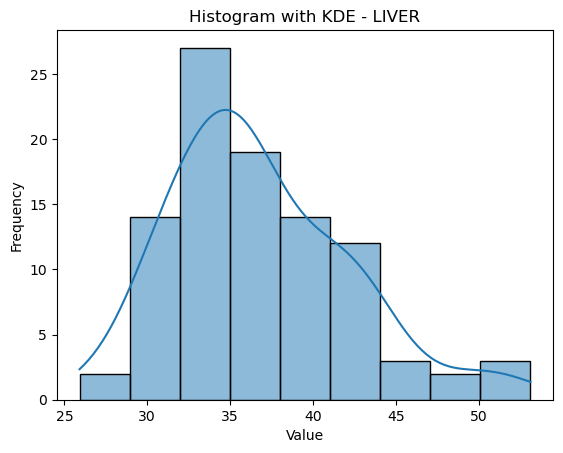

Shapiro-Wilk Test statistic = 0.9633, p-value = 0.0086
 Not normally distributed (reject H0)

 Analyzing column: HEART


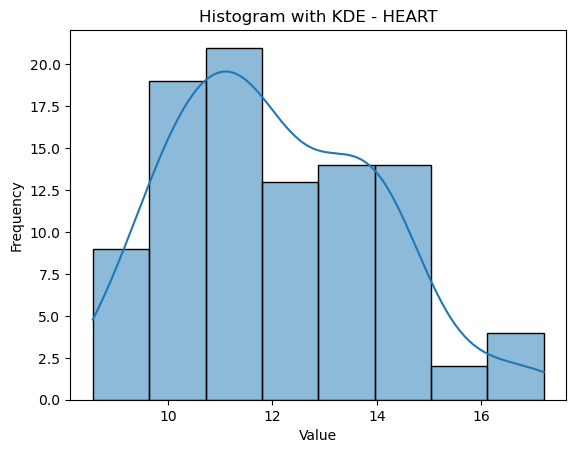

Shapiro-Wilk Test statistic = 0.9730, p-value = 0.0443
 Not normally distributed (reject H0)

 Analyzing column: INTESTINE


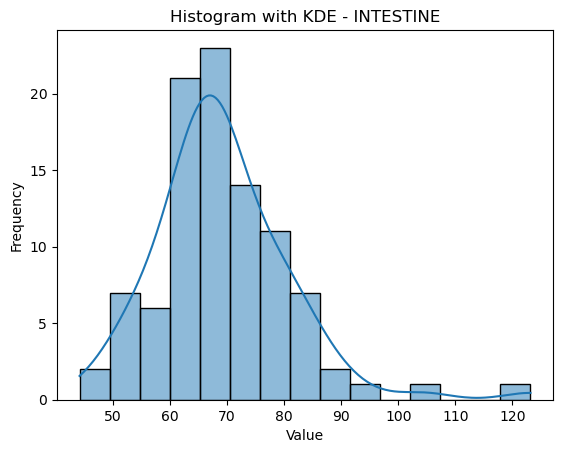

Shapiro-Wilk Test statistic = 0.9302, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: EMPTY MUSCULAR STOMACH


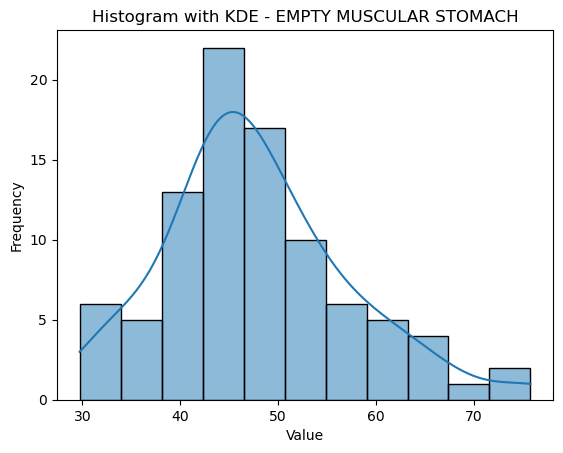

Shapiro-Wilk Test statistic = 0.9656, p-value = 0.0167
 Not normally distributed (reject H0)

 Analyzing column: GLANDULAR STOMACH


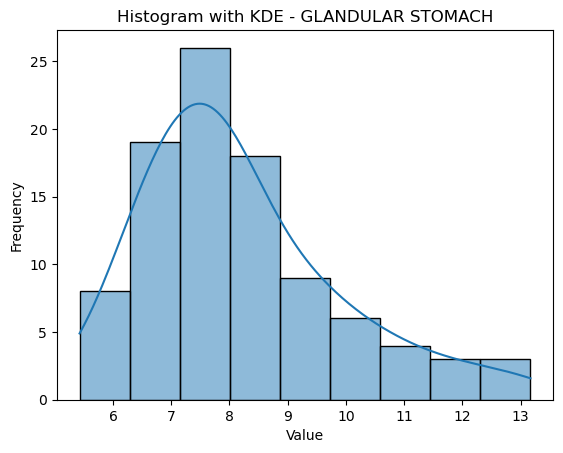

Shapiro-Wilk Test statistic = 0.9303, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: CRUDE PROTEIN


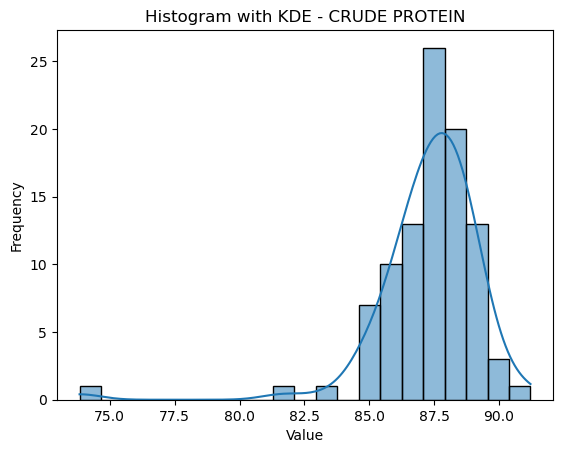

Shapiro-Wilk Test statistic = 0.7674, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: ETHER EXTRACT


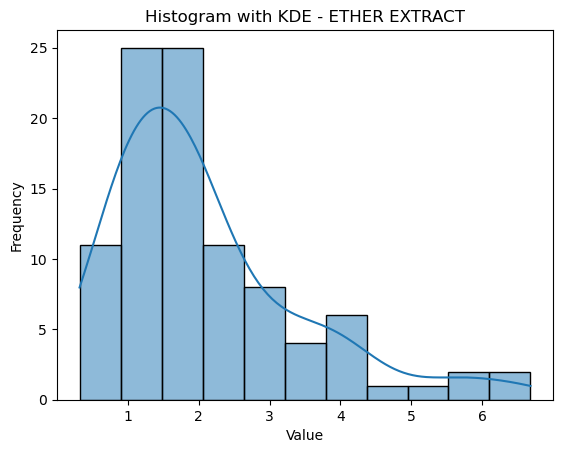

Shapiro-Wilk Test statistic = 0.8674, p-value = 0.0000
 Not normally distributed (reject H0)


In [13]:
# Checking if the data is normally distributed

for column in df.select_dtypes(include=[np.number]).columns:
    print(f"\n Analyzing column: {column}")
    data = df[column].dropna()  

    # Histogram + KDE
    sns.histplot(data, kde=True)
    plt.title(f"Histogram with KDE - {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test statistic = {stat:.4f}, p-value = {p:.4f}")
    if p > 0.05:
        print(" Likely normal (fail to reject H0)")
    else:
        print(" Not normally distributed (reject H0)")


> All columns in the dataset exhibit non-normal distributions, as confirmed by visual inspection and statistical tests 

<a id="chapter_5"></a>
## Data Preprocessing

In [14]:
# Missing Values
# Calculating the mean
mean_value = df['EMPTY MUSCULAR STOMACH'].mean()

# Replacing the NaNs with the mean
df['EMPTY MUSCULAR STOMACH'] = df['EMPTY MUSCULAR STOMACH'].fillna(mean_value)


In [15]:
# Separating the features from the target
features = df.drop(columns=['CRUDE PROTEIN'])
target = df['CRUDE PROTEIN']

# Scaling the features
scaler = RobustScaler() # since the data is not normally distributed and contains outliers, we opted to use the RobustScaler
X_scaled = scaler.fit_transform(features)


X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32)

<a id="chapter_6"></a>
## Cross-Validation

In [16]:
# Nested Cross Validation
k_outer = 5
k_inner = 3
cv_outer = KFold(n_splits=k_outer, random_state=seed, shuffle=True)
cv_inner = KFold(n_splits=k_inner, random_state=seed, shuffle=True)

We opted to use **nested cross-validation** instead of Monte Carlo because it gives a more confident and reliable estimate of how well the model will perform on new data. The **outer loop** is used to test the model, while the **inner loop** is used for hyperparameter tuning. This setup helps avoid overfitting during tuning and gives a more honest evaluation of the model’s generalization performance.

We chose **5 outer folds** because it gives a good balance between reliable performance estimates and computation time. For the **inner loop**, we used **3 folds** to keep hyperparameter tuning efficient without sacrificing too much accuracy..


<a id="chapter_7"></a>
## Genetic Programming

<a id="subchapter_7_1"></a>
### Problem Instance Definition 

In [17]:
DATASET_NAME = 'Sustavian'
FITNESS_FUNCTION = 'rmse'
MINIMIZATION = True

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



<a id="subchapter_7_2"></a>
### Solve 

In [18]:
LOG_DIR = './log/NEL_project/'
LOG_PATH = LOG_DIR + f'gp_{DATASET_NAME}.csv'
os.makedirs(LOG_DIR, exist_ok=True)
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)

In [19]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
TREE_FUNCTIONS = ['add', 'subtract', 'multiply', 'divide']
PROB_CONSTANT = 0.3
MAX_INIT_DEPTH = 3

<p align="left" style="margin: 5; font-size: 20px; font-weight: bold;">Common Problems in GP</p>

**Overfitting:**  
Model fits training data too closely and fails to generalize to new data.

**Bloat:**  
Excessive growth of tree size without fitness improvement, making models unnecessarily complex.

**Premature Convergence:**  
Population loses diversity too early and gets stuck in suboptimal solutions.



<p align="left" style="margin: 5; font-size: 20px; font-weight: bold;">Parameters that influence each problem:</p>

- **Overfitting:**  
  - `max_depth`: deeper trees can capture noise -> overfit  
  - `n_elites`: too many elites reduce exploration -> overfit  
  - `p_xo` (crossover rate): low rates limit diversity - overfit  
  - `initializer`: affects initial tree complexity

<p align="left" style="margin: 0; font-size: 10px;"> </p>

- **Bloat:**  
  - `max_depth`: limits max tree size  
  - `initializer`: e.g. 'grow' creates larger initial trees  
  - `n_elites`: preserves large individuals longer -> bloat  

<h1 align="left" style="margin: 0; font-size: 10px;"> </h1>

- **Premature Convergence:**  
  - `p_xo`: higher crossover keeps diversity  
  - `initializer`: influences initial population diversity  
  - `n_elites`: high elitism reduces diversity too fast  
  - `tournament_size`: bigger tournaments increase selection pressure -> less diversity
 
So our parameter search will focus on these key parameters

In [122]:
#Fixed Parameters

fixed_params = {
    # Search Space
    "init_depth": MAX_INIT_DEPTH,
    "tree_constants": TREE_CONSTANTS,
    "tree_functions": TREE_FUNCTIONS,
    "prob_const": PROB_CONSTANT,
    
    # Problem Instance
  
    "dataset_name": DATASET_NAME,
    "fitness_function": FITNESS_FUNCTION,
    "minimization": MINIMIZATION,

    # Solve settings
    "elitism": True,
    "n_iter": 20,
    "test_elite": True,
    "log_path": LOG_PATH,
    "log_level": 2,
    "verbose": 1,
    "n_jobs": 1,
    "seed": seed,
    
    # GP Instance
    "pop_size": 1000,
    "tournament_size": 7


}

# Parameters Grid Search

param_grid = {
    
    # Search Space
    "max_depth": [5, 8],

    # GP Instance
    "p_xo": [0.5, 0.8],
    "initializer": ['grow', 'rhh'],

    # Solve settings
    "n_elites": [1, 3]
}


In [123]:
def call_gp(fixed_params, param_grid, seed, set_max_depth = False):
    models = []
    keys, values = zip(*param_grid.items())
    for combo in product(*values):
        dynamic_params = dict(zip(keys, combo))
        full_params = {**fixed_params, **dynamic_params}
        if set_max_depth:
            full_params.update({'max_depth': full_params['init_depth']+15})
        model = gp(**full_params)
        res = {'model': model}
        res.update({'rmse_train': model.fitness.item()})
        res.update({'rmse_test': model.test_fitness.item()})
        res.update({'dynamic_params': dynamic_params})
        models.append(res)
    return models      


In [124]:
# Outer CV loop

data_cv_outer = [[learning_ix, test_ix] for learning_ix, test_ix in cv_outer.split(X, y)][0]

# Spliting the outer loop data
learning_ix, test_ix = data_cv_outer
X_learning, y_learning = X[learning_ix], y[learning_ix]
X_test, y_test = X[test_ix], y[test_ix]

print('\n' + '-'*41 + '\n')
print(f'Outer CV\nLearning shape: {X_learning.shape}\nTest shape: {X_test.shape}\n')

# Inner CV loop
results = []
data_cv_inner = [[train_ix, val_ix] for train_ix, val_ix in cv_inner.split(X_learning, y_learning)]

for i_inner, (train_ix, val_ix) in enumerate(data_cv_inner):
    print('-----\nInner CV {}'.format(i_inner))

    # Spliting inner data
    X_train, y_train = X_learning[train_ix], y_learning[train_ix]
    X_val, y_val = X_learning[val_ix], y_learning[val_ix]

    print(f'Training shape: {X_train.shape}\nValidation shape: {X_val.shape}\n')

    fixed_params.update({
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_val, 'y_test': y_val,
    })

    # Fit
    LOG_PATH = LOG_DIR+'gp_'+DATASET_NAME+'_'+str(i_inner)+'.csv'
    if os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)
    fixed_params.update({'log_path': LOG_PATH})

    # Running the model
    res = call_gp(fixed_params, param_grid, seed=(seed + i_inner))

    # Collecting results
    results.append(res)



-----------------------------------------

Outer CV
Learning shape: torch.Size([76, 13])
Test shape: torch.Size([20, 13])

-----
Inner CV 0
Training shape: torch.Size([50, 13])
Validation shape: torch.Size([26, 13])

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     Sustavian           |       0      |   39.52196502685547   |   39.80461883544922      |   0.5557873249053955   |      3           |
|     Sustavian           |       1      |   39.52196502685547   |   39.80461883544922      |   0.3259129524230957   |      3           |
|     Sustavian           |       2      |   11.499371528625488  |   11.139

In [125]:
# Getting the best model

all_models = [model for fold_result in results for model in fold_result]

# Sort by test RMSE 
sorted_models = sorted(all_models, key=lambda x: x['rmse_test'])

best_model = sorted_models[0]

print('\n Best Model Found:')
print(f"  RMSE (Train): {best_model['rmse_train']:.4f}")
print(f"  RMSE (Test):  {best_model['rmse_test']:.4f}")
print(f"  Parameters:   {best_model['dynamic_params']}")



 Best Model Found:
  RMSE (Train): 1.0072
  RMSE (Test):  0.8449
  Parameters:   {'max_depth': 8, 'p_xo': 0.5, 'initializer': 'rhh', 'n_elites': 1}


In [127]:
best_model

{'model': <slim_gsgp.algorithms.GP.representations.tree.Tree at 0x1d9de5f9d60>,
 'rmse_train': 1.007168173789978,
 'rmse_test': 0.8449201583862305,
 'dynamic_params': {'max_depth': 8,
  'p_xo': 0.5,
  'initializer': 'rhh',
  'n_elites': 1}}

In [128]:
model = best_model['model']

In [129]:
y_pred = model.predict(X_test)
y_pred

tensor([88.3557, 87.3691, 87.6987, 86.7637, 87.8037, 87.4263, 86.0190, 86.1217,
        87.7359, 86.5575, 85.4442, 87.8895, 89.1841, 88.8525, 86.6890, 88.5716,
        86.9361, 88.4323, 85.9541, 88.1683])

In [130]:
y_test

tensor([86.1055, 86.1435, 86.4169, 87.5331, 88.1924, 86.2464, 86.5115, 84.9951,
        88.9662, 87.1134, 73.8372, 86.5774, 87.3628, 88.5818, 86.0451, 87.2786,
        87.6940, 88.6367, 86.5774, 87.4385])

<a id="subchapter_7_3"></a>
### Evolution Graphs

In [131]:
pd.read_csv(LOG_PATH, header=None).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,StandardGP,d9030b74-3318-11f0-9cb1-00f48dd34ab0,Sustavian,43,0,39.685497,0.444950,3540.0,39.482655,3,0.0,7.106932,2
1,StandardGP,d9030b74-3318-11f0-9cb1-00f48dd34ab0,Sustavian,43,1,39.685497,0.579628,4420.0,39.482655,3,0.0,91.472080,2
2,StandardGP,d9030b74-3318-11f0-9cb1-00f48dd34ab0,Sustavian,43,2,10.410889,0.559438,5336.0,10.694530,3,0.0,342.039370,2
3,StandardGP,d9030b74-3318-11f0-9cb1-00f48dd34ab0,Sustavian,43,3,10.410889,0.619105,6508.0,10.694530,3,0.0,2580.605700,2
4,StandardGP,d9030b74-3318-11f0-9cb1-00f48dd34ab0,Sustavian,43,4,10.410889,0.709516,7742.0,10.694530,3,0.0,177.189590,2


<a id="subchapter_7_3_1"></a>
#### Variation of RMSE across Models

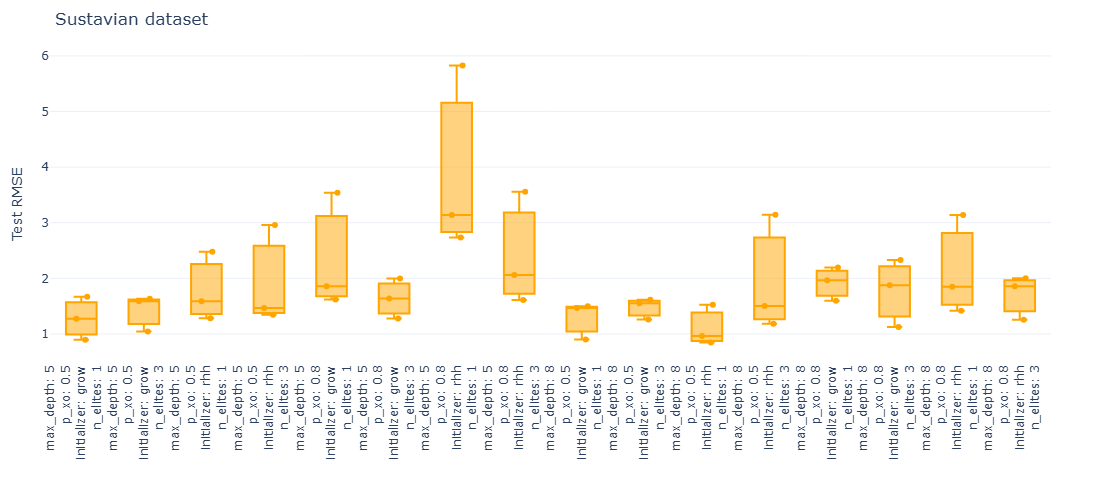

In [132]:
# Boxplots for comparison of Test RMSE Distributions across Model 

rmse_by_config = defaultdict(list)

for split in results:
    rmse_train = []
    rmse_test = []
    
    for result in split:
        key = ''
        for k, v in result['dynamic_params'].items():
            key += k+': '+str(v)+' <br /> '
        rmse_by_config[key].append(result['rmse_test'])

fig = go.Figure()
for config, rmse_values in rmse_by_config.items():
    fig.add_trace(go.Box(
        y=rmse_values,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line=dict(color='orange'),
        name=config
    ))

fig.update_layout(
    title=DATASET_NAME+' dataset',
    xaxis_title='',
    yaxis_title='Test RMSE',
    height=500, width=1100,
    xaxis_tickangle=-90,
    yaxis_range=[0,None],
    margin=dict(l=50, r=50, t=50, b=20),
    showlegend=False,
    template='plotly_white'
)

fig.show()

Overall, the test RMSE ranges from 1 to 6. The best-performing model shows stable results with a median RMSE around 0.96. In contrast, the worst-performing model is also the least stable, with RMSE values varying between 2.73 and 5.8. The rhh initializer generally leads to less consistent performance, and using a higher crossover probability (p_xo = 0.8) seems to slightly worsen performance compared to a lower value.

<a id="subchapter_7_3_2"></a>
#### Train vs Test Fitness 

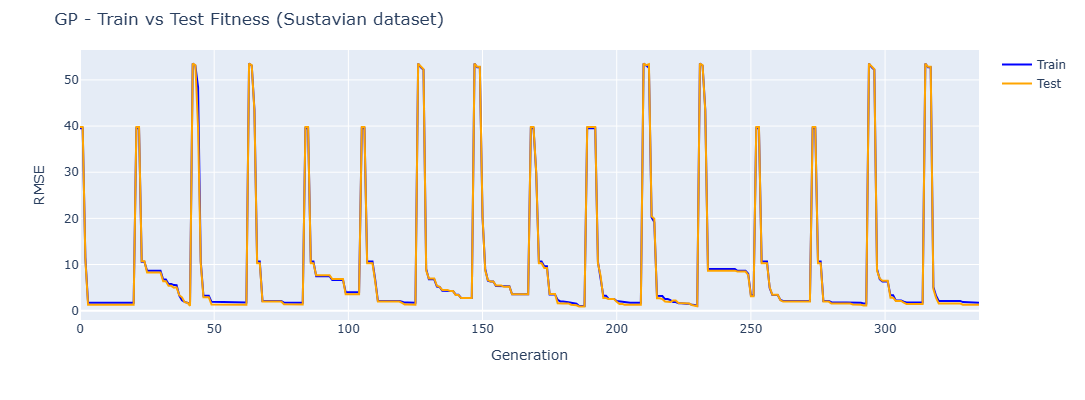

In [143]:
# General graph

fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Train vs Test Fitness ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='RMSE'
)
fig.update_yaxes(range=[0, None])
fig.show()



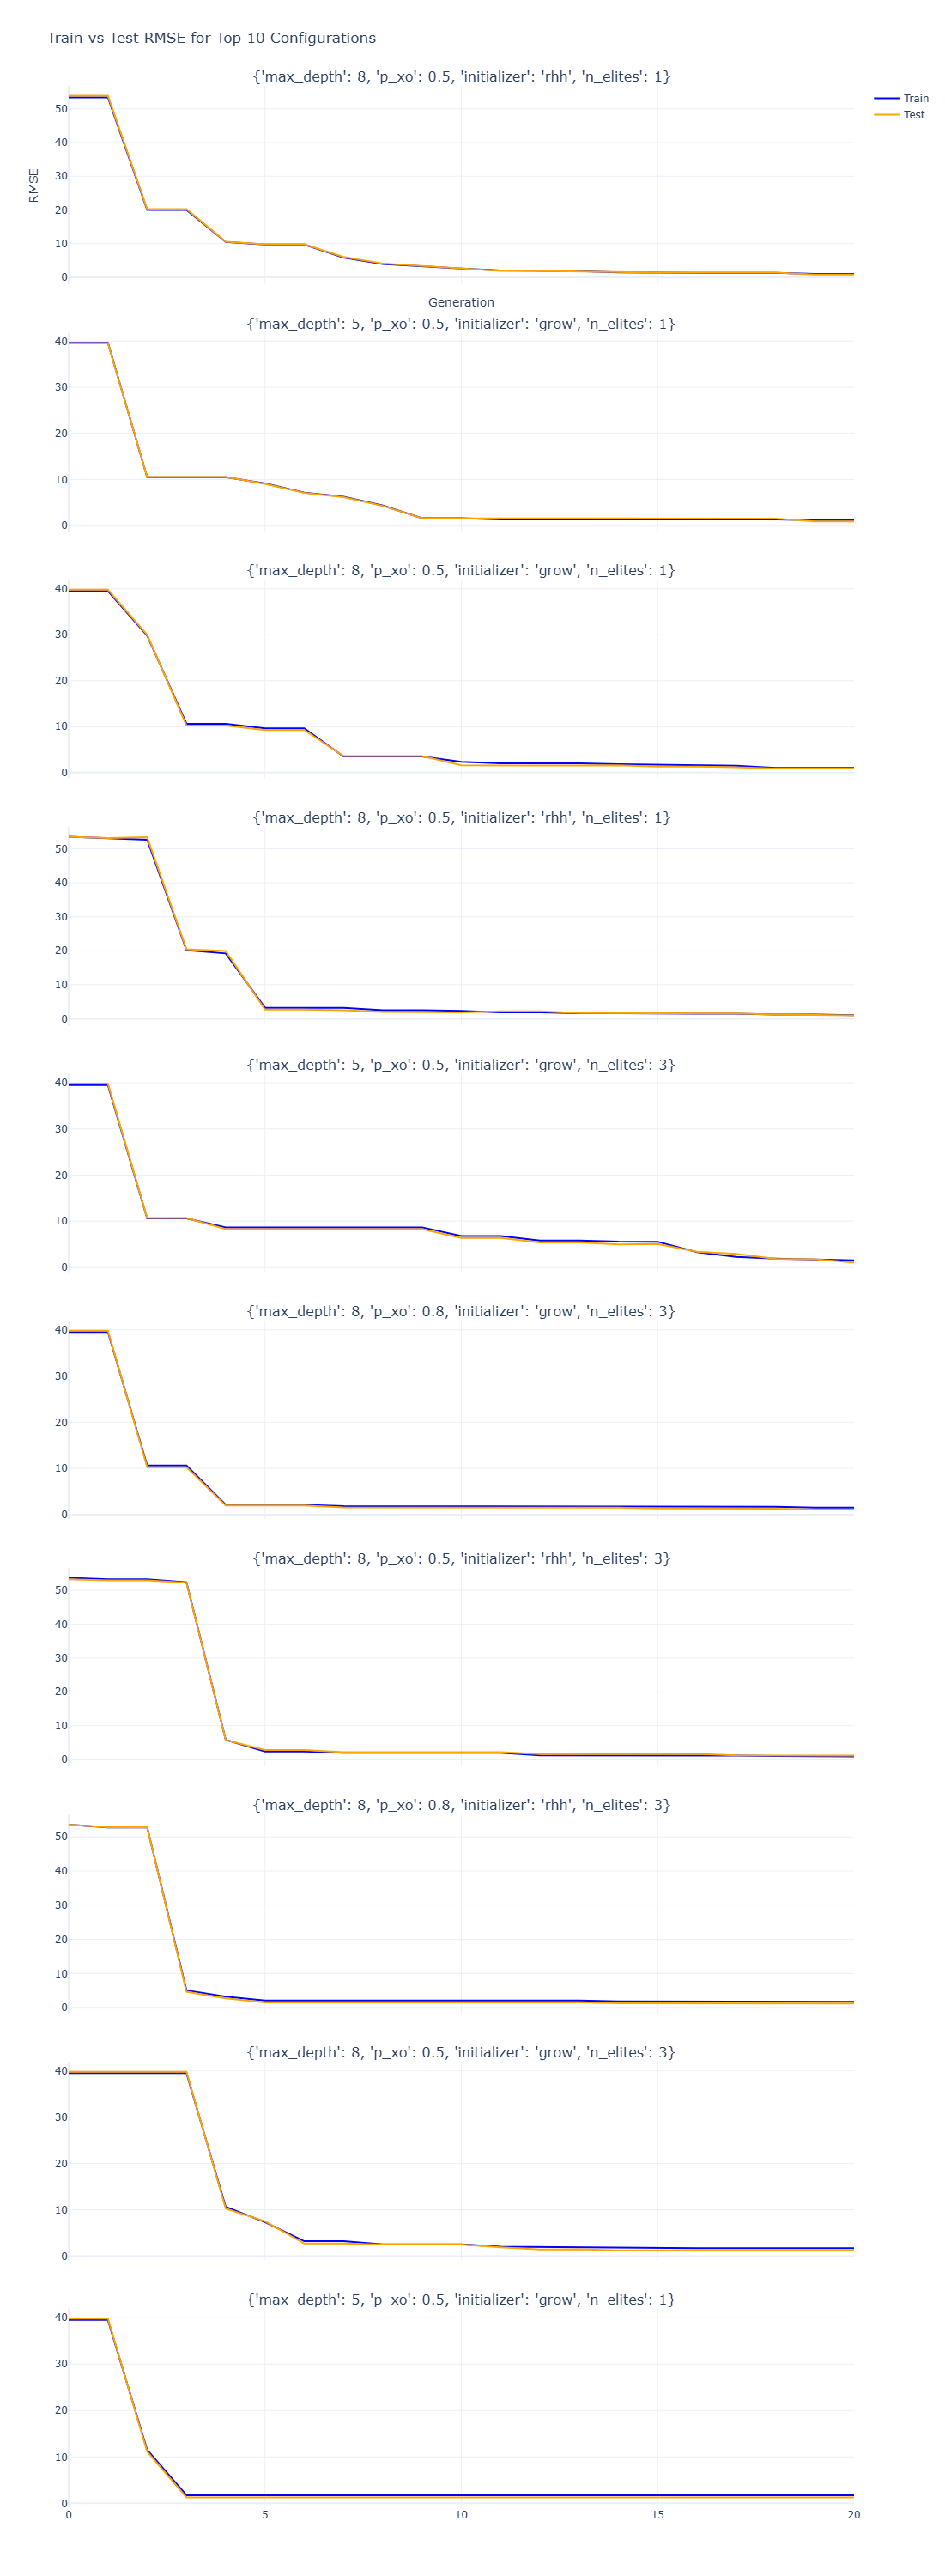

In [134]:
# Some subplots

# Flatten results, keep original config index within each fold
flat_results = []
for fold_id, fold in enumerate(results):
    for config_idx, res in enumerate(fold):
        flat_results.append((fold_id, config_idx, res))

# Sort by test RMSE 
flat_results.sort(key=lambda x: x[2]['rmse_test'])

# Take top N
N = 10
flat_results = flat_results[:N]

GENS_PER_RUN = fixed_params['n_iter'] + 1

fig = make_subplots(
    rows=N, cols=1, shared_xaxes=True,
    subplot_titles=[str(res['dynamic_params']) for _, _, res in flat_results],
    vertical_spacing=0.02
)

for idx, (fold_id, config_idx, result) in enumerate(flat_results):
    LOG_PATH = f'{LOG_DIR}gp_{DATASET_NAME}_{fold_id}.csv'
    if not os.path.exists(LOG_PATH):
        continue

    log_df = pd.read_csv(LOG_PATH, header=None)

    # Use original config_idx to slice the right chunk in the log
    start = config_idx * GENS_PER_RUN
    end = start + GENS_PER_RUN
    chunk = log_df.iloc[start:end]

    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 5],  # Train RMSE
        mode='lines', name='Train' if idx == 0 else None,
        showlegend=(idx == 0),
        line=dict(color=train_color)
    ), row=idx + 1, col=1)

    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 8],  # Test RMSE
        mode='lines', name='Test' if idx == 0 else None,
        showlegend=(idx == 0),
        line=dict(color=test_color)
    ), row=idx + 1, col=1)

fig.update_layout(
    height=300 * N,
    width=1000,
    title_text=f'Train vs Test RMSE for Top {N} Configurations',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    template='plotly_white',
    showlegend=True
)

fig.show()


In the Train vs Test RMSE plot, the curves for training and test errors are nearly overlapping across generations. This indicates that the model is generalizing well, showing consistent performance on both seen (training) and unseen (test) data. The absence of a significant gap between these curves suggests that overfitting is minimal, and the evolutionary process is producing robust solutions that transfer effectively to validation data.<br>

Overall, the graphs show signs of early convergence, as both train and test RMSE flatten out within the first few generations. This suggests that the population may be losing diversity quickly and converged prematurely to a locally optimal solution. Another insight is that generations initialized with the `grow` method exhibit lower fitness (around 40) in the initial generations compared to those initialized with `rhh` (around 50).


<a id="subchapter_7_3_3"></a>
#### Fitness vs Size Evolution

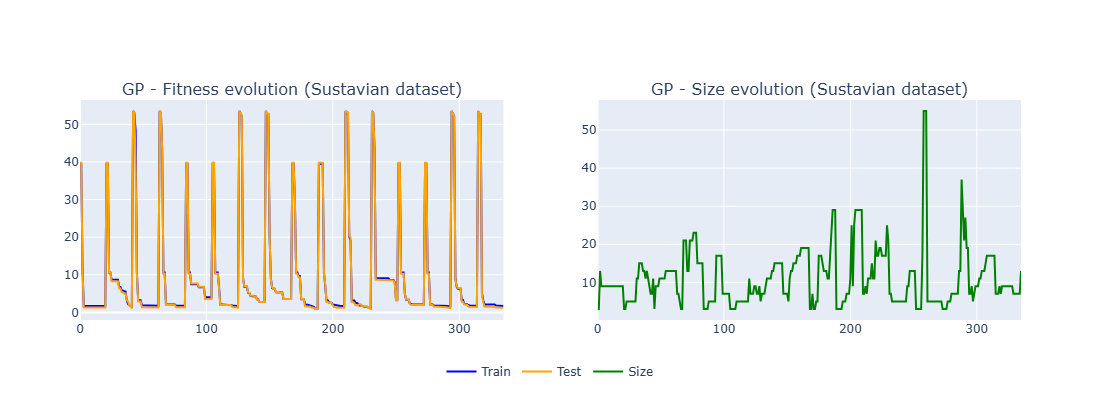

In [135]:
# General graph
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('GP - Fitness evolution ('+DATASET_NAME+' dataset)', 'GP - Size evolution ('+DATASET_NAME+' dataset)')
)

fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,9].values, 
                         mode='lines', name='Size',line=dict(color=size_color)), row=1, col=2)
fig.update_layout(
    width=1000,
    height=400, 
    showlegend=True,
    yaxis_range=[0,None],
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    )
)
fig.show()


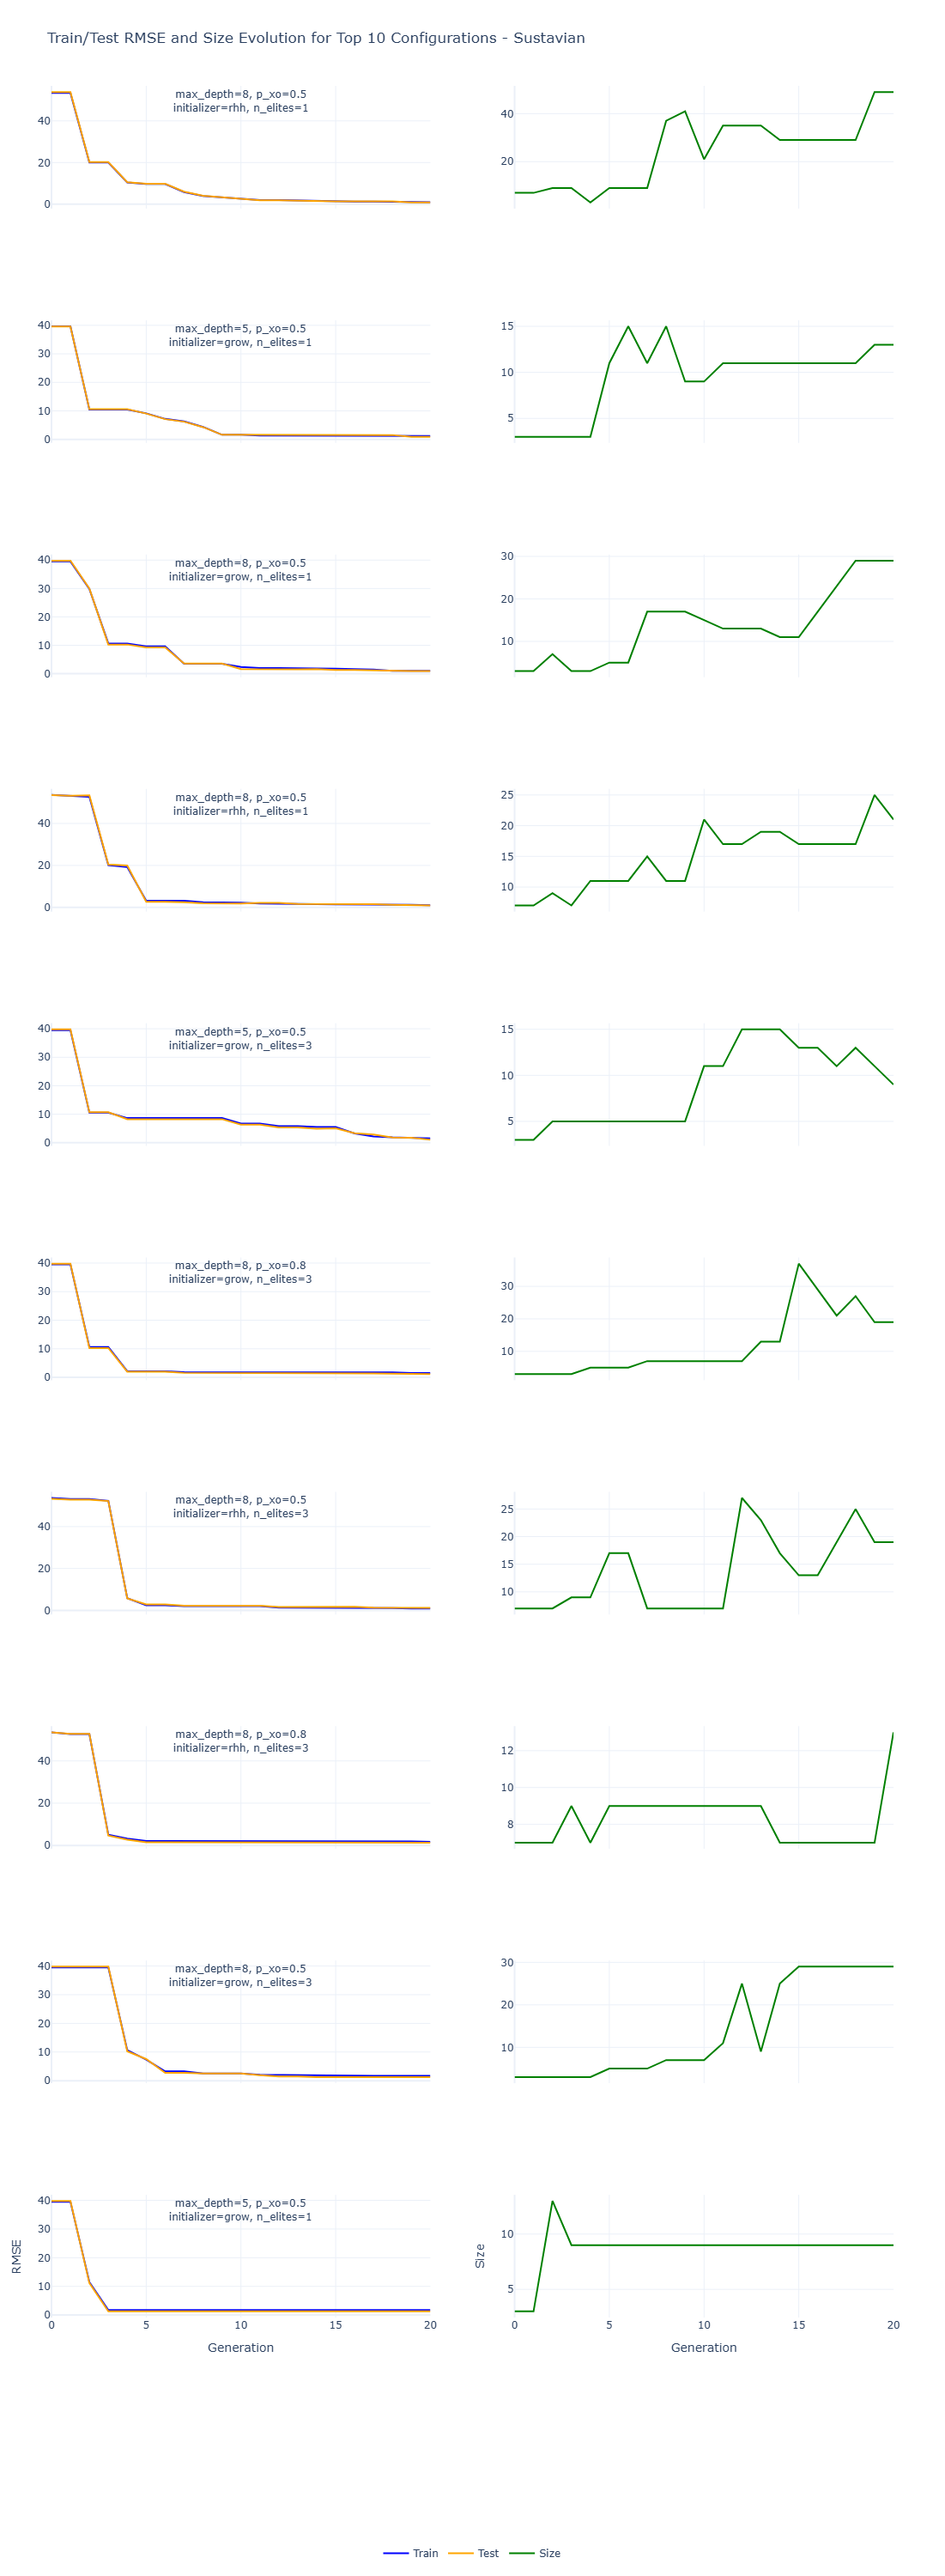

In [136]:
def param_title_str_multiline(params):
    items = [f"{k}={v}" for k, v in params.items()]
    half = (len(items) + 1) // 2
    first_line = ", ".join(items[:half])
    second_line = ", ".join(items[half:])
    return first_line + "<br>" + second_line if second_line else first_line

# Take top N
N = 10
flat_results = flat_results[:N]

GENS_PER_RUN = fixed_params['n_iter'] + 1

fig = make_subplots(
    rows=N, cols=2,
    shared_xaxes=True,
    horizontal_spacing=0.1,
    vertical_spacing=0.05,
    column_widths=[0.45, 0.45]
)

for idx, (fold_id, config_idx, result) in enumerate(flat_results):
    LOG_PATH = f'{LOG_DIR}gp_{DATASET_NAME}_{fold_id}.csv'
    if not os.path.exists(LOG_PATH):
        print(f"Missing log for fold {fold_id}, skipping.")
        continue

    log_df = pd.read_csv(LOG_PATH, header=None)

    start = config_idx * GENS_PER_RUN
    end = start + GENS_PER_RUN
    chunk = log_df.iloc[start:end]

    show_legend = idx == 0

    # Train RMSE
    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 5],
        mode='lines',
        name='Train',
        line=dict(color=train_color),
        showlegend=show_legend
    ), row=idx + 1, col=1)

    # Test RMSE
    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 8],
        mode='lines',
        name='Test',
        line=dict(color=test_color),
        showlegend=show_legend
    ), row=idx + 1, col=1)

    # Size
    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 9],
        mode='lines',
        name='Size',
        line=dict(color=size_color),
        showlegend=show_legend
    ), row=idx + 1, col=2)

    # Parameters annotation
    fig.add_annotation(
        x=0.5,
        y=1,
        xref=f"x domain",
        yref=f"y domain",
        text=param_title_str_multiline(result['dynamic_params']),
        showarrow=False,
        font=dict(size=12),
        align='center',
        row=idx + 1, col=1
    )

fig.update_layout(
    height=300 * N,
    width=1100,
    title_text=f'Train/Test RMSE and Size Evolution for Top {N} Configurations - {DATASET_NAME}',
    template='plotly_white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=-0.1,
        xanchor='center',
        x=0.5,
        font=dict(size=12),
        bgcolor='rgba(0,0,0,0)'
    ),
    margin=dict(b=150, l=60, r=60, t=100)
)

fig.update_xaxes(title_text='Generation', row=N, col=1)
fig.update_xaxes(title_text='Generation', row=N, col=2)
fig.update_yaxes(title_text='RMSE', row=N, col=1)
fig.update_yaxes(title_text='Size', row=N, col=2)

fig.show()


Across the evaluated configurations, the models demonstrate excellent convergence behavior, with both train and test RMSE rapidly decreasing and stabilizing within the first few generations. However, this early flattening of RMSE is consistently accompanied by a steady increase in model complexity. This pattern indicates early convergence, where the search process prematurely settles, and bloat, where complexity grows without further improvements in performance, ultimately reducing model interpretability.

<a id="subchapter_7_3_4"></a>
#### Fitness Diversity

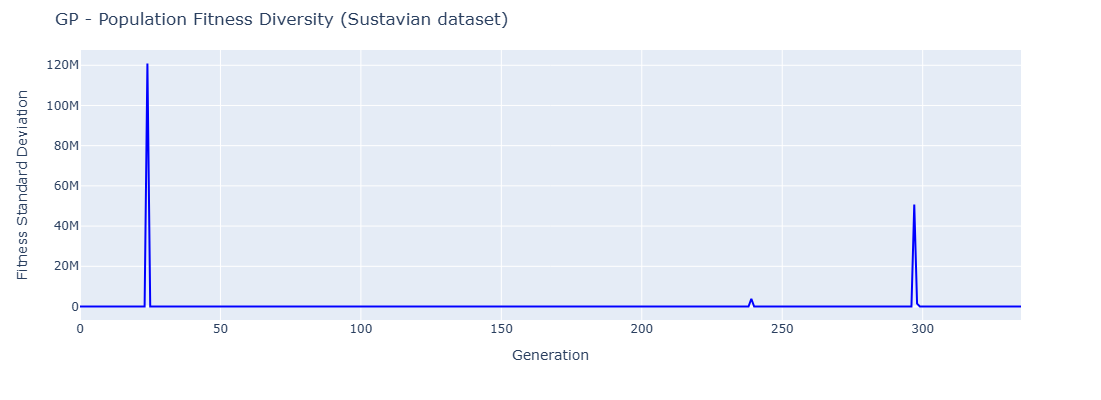

In [138]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,11].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Population Fitness Diversity ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='Fitness Standard Deviation'
)
fig.show()


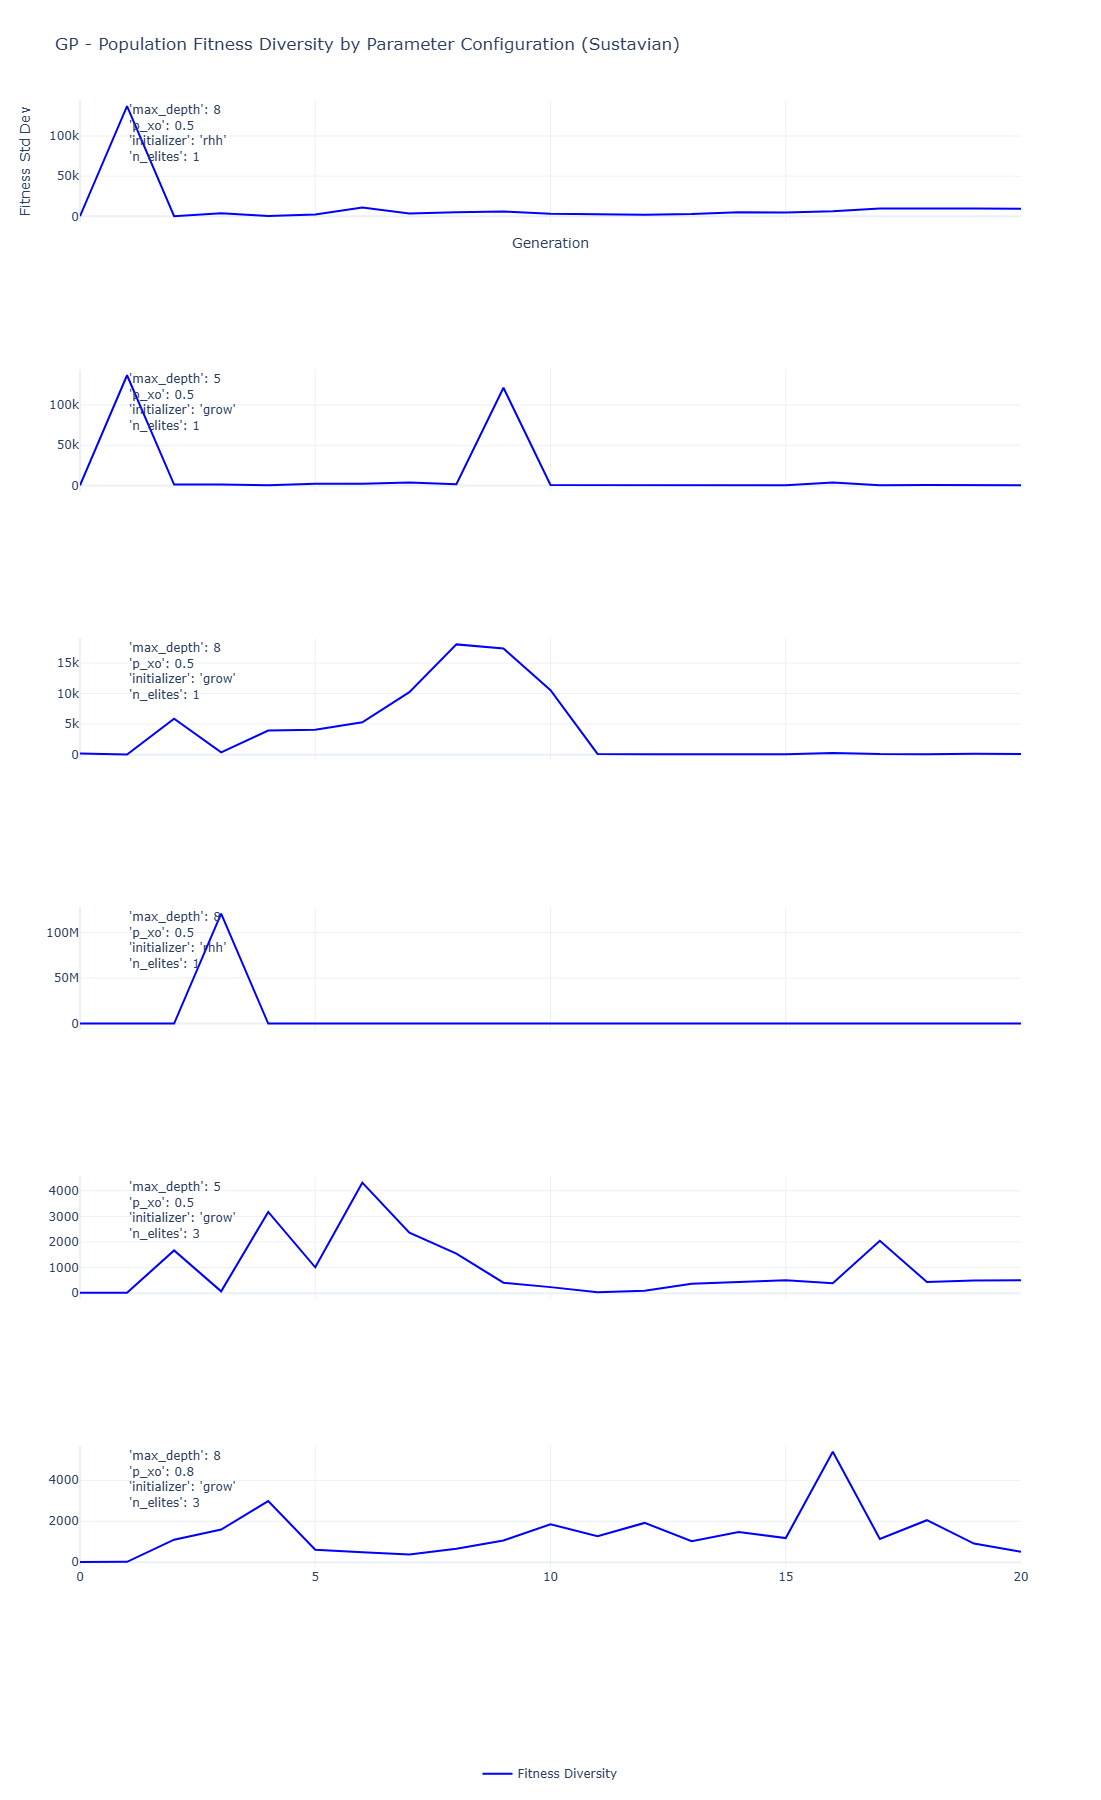

In [139]:
N = 6
GENS_PER_RUN = fixed_params['n_iter'] + 1

fig = make_subplots(
    rows=N, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=[""] * N 
)

fold_seen_count = {}

for idx, (fold_id, config_idx, result) in enumerate(flat_results[:N]):
    LOG_PATH = f'{LOG_DIR}gp_{DATASET_NAME}_{fold_id}.csv'
    if not os.path.exists(LOG_PATH):
        continue

    log_df = pd.read_csv(LOG_PATH, header=None)

    seen = fold_seen_count.get(fold_id, 0)
    fold_seen_count[fold_id] = seen + 1

    start = seen * GENS_PER_RUN
    end = start + GENS_PER_RUN
    chunk = log_df.iloc[start:end]

    fitness_diversity = chunk.iloc[:, 11].values

    fig.add_trace(go.Scatter(
        y=fitness_diversity,
        mode='lines',
        name='Fitness Diversity' if idx == 0 else None,
        line=dict(color='blue'),
        showlegend=(idx == 0)
    ), row=idx + 1, col=1)

    # Parameter configoration above plot
    param_lines = str(result['dynamic_params']).replace('{', '').replace('}', '').split(',')
    param_text = '<br>'.join(p.strip() for p in param_lines)

    fig.add_annotation(
    text=param_text,
    x=0.05,
    xref=f"x domain",
    yref=f"y domain",
    y=1, 
    showarrow=False,
    font=dict(size=12),
    align='left',
    row=idx + 1, col=1

    )

fig.update_layout(
    height=300 * N,
    width=900,
    title_text=f'GP - Population Fitness Diversity by Parameter Configuration ({DATASET_NAME})',
    xaxis_title='Generation',
    yaxis_title='Fitness Std Dev',
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5,
        font=dict(size=12)
    ),
    margin=dict(t=100, b=100)
)

fig.show()


Across these GP runs, the scale of fitness standard deviation varies dramatically, from hundreds to millions, making the graphs visually quite different. The initial fitness spread differs. The line shows the fitness standard deviation within each generation, so spikes likely indicate a generation with very different individual fitness scores. Interestingly, the runs using the `rhh` initializer seem to exhibit more extreme values in fitness diversity. The overall diversity trend varies; some seem stable, others more erratic, and a few show decreasing diversity later on

#### Summary: 
**Bloat** <br>
Across runs, model complexity steadily increases even after RMSE plateaus,clear bloat, where larger trees don’t yield better performance and hurt interpretability.

**Overfitting** <br>
Overfitting is minimal. Train and Test RMSE curves stay closely aligned, indicating strong generalization across generations.

**Early Convergence** <br>
RMSE flattens quickly, usually within the first few generations, signaling early convergence.
This suggests the population may be losing diversity too soon and settling on suboptimal solutions.

<a id="chapter_8"></a>
### To Evaluate

We will use these evaluation metrics, MAE, MSE, and correlation coefficients, to measure the performance of each algorithm. After calculating these metrics, we will apply statistical tests to determine whether the observed differences in performance are statistically significant, following the approach recommended by Rainio et al. (2024).


In [140]:
# Converting PyTorch tensors to NumPy arrays

y_true_np = y_test.detach().cpu().numpy()
y_pred_np =  y_pred.detach().cpu().numpy()

In [141]:
# Computing Spearman's rank correlation
spearman_corr_gp, _ = spearmanr(y_true_np, y_pred_np)

print("Spearman’s correlation (rs):", spearman_corr_gp)

Spearman’s correlation (rs): 0.5174878139558973


In [142]:
# Computing MAE and MSE
mae_gp = mean_absolute_error(y_true_np, y_pred_np)
mse_gp = mean_squared_error(y_true_np, y_pred_np)

print("MAE:", mae_gp)
print("MSE:", mse_gp)


MAE: 1.4882190227508545
MSE: 7.856797218322754
